Strategy rules:

1. Check if today's close is in the bottom n % of the day's range
2. If condition is met then enter on the close and exit the next day's close, unless the signal is repeated.

In [ ]:
#import libraries
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime

%matplotlib inline

/Users/saurabhchopda/AlgoTrading/Stock-Prediction-Models/stock-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#define starting variables
SYMBOL = "AMZN"
STARTING_BALANCE = 1000
PCT_THRESH = 10

In [ ]:
#define date range
START = datetime.datetime(2022, 1, 1)
END = datetime.datetime.today()
YEARS = (END - START).days/ 365.25

In [4]:
#download data
price = yf.download(SYMBOL, start=START, end=END)

price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400
2024-01-03,149.199997,151.050003,148.330002,148.470001,148.470001,49425500
2024-01-04,145.589996,147.380005,144.050003,144.570007,144.570007,56039800
2024-01-05,144.690002,146.589996,144.529999,145.240005,145.240005,45124800
2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100


In [5]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], axis=1)

price.tail()

,Open,High,Low,Close
Date,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999
2024-10-29,188.580002,191.460007,187.820007,190.830002
2024-10-30,194.699997,195.610001,192.419998,192.729996
2024-10-31,190.509995,190.600006,185.229996,186.399994
2024-11-01,199.000000,200.500000,197.020004,197.929993


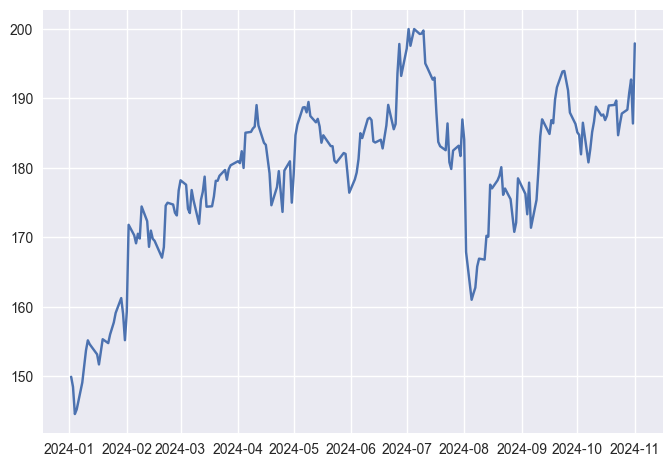

In [6]:
#plot chart
plt.style.use('seaborn-v0_8')
plt.plot(price.Close)
plt.show()

In [7]:
#calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

,Open,High,Low,Close,Return,Bench_Bal
Date,,,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999,1.002981,1256.519767
2024-10-29,188.580002,191.460007,187.820007,190.830002,1.012952,1272.794045
2024-10-30,194.699997,195.610001,192.419998,192.729996,1.009956,1285.466585
2024-10-31,190.509995,190.600006,185.229996,186.399994,0.967156,1243.246869
2024-11-01,199.000000,200.500000,197.020004,197.929993,1.061856,1320.149419


In [8]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-19.49

In [9]:
#calculate additional columns for strategy

#daily range
price['Range'] = price.High - price.Low
#distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct
Date,,,,,,,,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999,1.002981,1256.519767,1333.955911,-77.436145,2.000000,0.179993,8.999634
2024-10-29,188.580002,191.460007,187.820007,190.830002,1.012952,1272.794045,1333.955911,-61.161866,3.639999,3.009995,82.692171
2024-10-30,194.699997,195.610001,192.419998,192.729996,1.009956,1285.466585,1333.955911,-48.489326,3.190002,0.309998,9.717784
2024-10-31,190.509995,190.600006,185.229996,186.399994,0.967156,1243.246869,1333.955911,-90.709043,5.370010,1.169998,21.787633
2024-11-01,199.000000,200.500000,197.020004,197.929993,1.061856,1320.149419,1333.955911,-13.806493,3.479996,0.909988,26.149124


In [10]:
#identify entries and allocate trading fees
price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))

In [11]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2024-10-28,189.570007,190.210007,188.210007,188.389999,1.002981,1256.519767,1333.955911,-77.436145,2.000000,0.179993,8.999634,False,1.0,1000.0
2024-10-29,188.580002,191.460007,187.820007,190.830002,1.012952,1272.794045,1333.955911,-61.161866,3.639999,3.009995,82.692171,False,1.0,1000.0
2024-10-30,194.699997,195.610001,192.419998,192.729996,1.009956,1285.466585,1333.955911,-48.489326,3.190002,0.309998,9.717784,False,1.0,1000.0
2024-10-31,190.509995,190.600006,185.229996,186.399994,0.967156,1243.246869,1333.955911,-90.709043,5.370010,1.169998,21.787633,False,1.0,1000.0
2024-11-01,199.000000,200.500000,197.020004,197.929993,1.061856,1320.149419,1333.955911,-13.806493,3.479996,0.909988,26.149124,False,1.0,1000.0


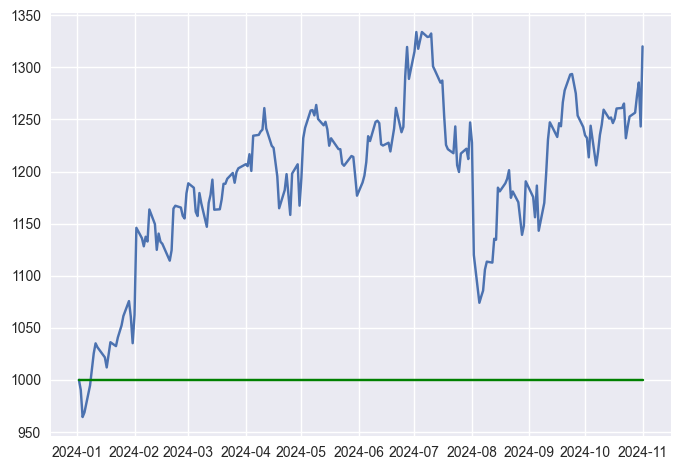

In [12]:
#plot balance
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal, color="g")

plt.show()

In [13]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

0.0

In [21]:
#calculate metrics
bench_return = round(((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

KeyError: True

In [16]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225','^BSESN']

In [17]:
#create backtesting function
def backtest(s):
    #download data
    price = yf.download(s, start=START, end=END)
    
    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], axis=1)
    
    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
    
    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100
    
    #identify entries and allocate trading fees
    price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))
    
    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
    
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr

In [19]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)
    print(bc)
    print(sc)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[25.29]
[10.94]
[25.29, 13.87]
[10.94, 6.35]
[25.29, 13.87, 28.69]
[10.94, 6.35, 8.48]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[25.29, 13.87, 28.69, 11.81]
[10.94, 6.35, 8.48, 17.3]
[25.29, 13.87, 28.69, 11.81, 17.32]
[10.94, 6.35, 8.48, 17.3, 1.07]


[*********************100%%**********************]  1 of 1 completed

[25.29, 13.87, 28.69, 11.81, 17.32, 13.14]
[10.94, 6.35, 8.48, 17.3, 1.07, 0.22]


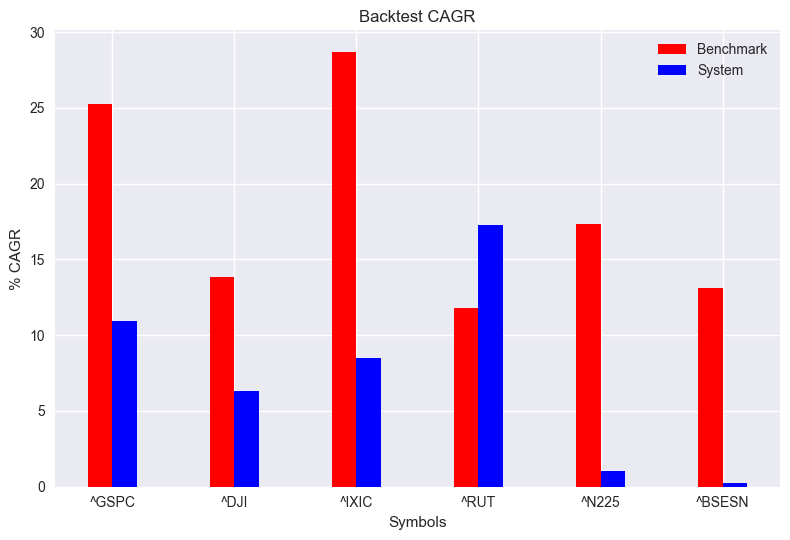

In [20]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark', color="red")
plt.bar(x_indices + width / 2, sc, width = width, label = 'System', color="blue")
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.show()